In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyvista as pv
from itkwidgets import view
from ipywidgets import interactive
from itkwidgets import view
from pyvista import set_plot_theme
set_plot_theme('document')
%matplotlib widget

# Reproducible Landscapes

### John Armitage (IFP Energies Nouvelles)



### A presentation in two parts:

**Part 1**: Some research into flow routing.

**Part 2**: How to make it reproducible.

Reproducible research is something we must all strive for. Replication in academic code is poor. In software production (think keeping amazon.com running) everything must be reproducible: outages cost money.

I will present some ideas. *All models are wrong but some are useful*, but only if they are reproducible.

# Part 1: A landscape evolution model and the problem of resolution

* It is known that resolution impacts landscape evolution models (LEMs) ([Schoorl et al., 2000](#))
* The resolution dependence of LEMs is caused by how run-off is routed down the model surface.
* It has been demonstrated that either distributing flow down all slopes (multiple flow direction, MFD), or simply allowing flow to descent down the steepest slope (single flow direction, SFD), gives different outcomes for landscape evolution models ([Schoorl et al., 2000](#), [Pelletier 2004](https://doi.org/10.1029/2004GL020802)).

### A measure of the impact of resolution

* The sediment flux out of the model domain is independent of resolution.
* The wavelength of valleys should be independent of model resolution.

In [2]:
elevation = pv.read('MFDnodetonode/u_solution_128_500000000.vtu')
flux = pv.read('MFDnodetonode/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDnodetonode = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [3]:
view(geometries=warpMFDnodetonode)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### River width and grid size

* How wide are rivers relative to model grids (data from [Allen & Palvesky, 2018](https://doi.org/10.1126/science.aat0636))?

In [4]:
data = gpd.read_file('data/GRWL_summaryStats.shp')
fig = plt.figure()
ax = data['width_mean'].plot(kind='hist',bins=20)
ax.set_xlabel('Mean river width (m)')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### A landscape evolution model

In this study I will assume landscape evolution can be effectively simulated with the classic set of diffusive equations described in [Smith & Bretherton, 1972](https://doi.org/10.1029/WR008i006p01506):
\begin{equation}
\frac{\partial z}{\partial t} = \nabla \left[ \left(\kappa + c q_{w}^{n}\right) \nabla z \right] + U
\end{equation}
where $\kappa$ is a linear diffusion coefficient, $c$ is the fluvial diffusion coefficient, $q_{w}$ is the water flux, $n$ is the water flux exponent, and $U$ is uplift.

### Example run

The intial condition will be taken from a region near the north of the Khovskol Lake in northern in Mongolia.

![mongolia](figures/mongolia.png)

This is done by selecting the coordinates in the ```bounds```. The resolution is set along the $x$ axis, and the model domain is then created from the function ```intialise```.

In [5]:
from flem import initialise, solve_flem
from fenics import plot

# Domain dimensions
dem = 1  # 1=input is a DEM
bounds = [98.685, 51.208, 98.911, 51.337]  # coordinates to pull from SRTM data
res = 128  # model resolution in the x-direction
model_space, u_n, mesh, V, bc = initialise(dem, bounds, res)  # create the model domain

In [6]:
# Plot the initial condition
plt.figure(figsize=(6, 6))
pl2 = plot(u_n)
plt.gca().invert_yaxis()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
# Physical parameters
physical_space = [1e+0,1e-5,1.5,1,1e-4] # [kappa, c, nexp, alpha, U]
# 0 = MFD node-to-node; 1 = MFD cell-to-cell; 2 = SD node-to-node; 3 = SD cell-to-cell
flow = 0
# Time
dt = 1e4
num_steps = 5
# Output
out_time = 10
# Plot stuff
plot = 0
# Calculate valley to valley wavelength
statistics = 0

In [8]:
name = 'mongolia'
dirtest = './%s/' % name
directory = os.path.dirname(dirtest)
if not os.path.exists(directory) :
  os.makedirs(directory)

In [9]:
[sed_flux, time, wavelength] = solve_flem(model_space,physical_space,flow,u_n, mesh, V, bc,dt,num_steps,out_time,plot,statistics,name)

In [10]:
elevation = pv.read('mongolia/u_solution_128_4000000.vtu')
flux = pv.read('mongolia/q_solution_128_4000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warp = flux.warp_by_scalar(scalars='elevation',factor=1e-4)
view(geometries=warp)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### How to route water?

In [11]:
img=mpimg.imread('figures/MFDandSFD.png')
plt.figure(figsize=(16, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
elevation = pv.read('SFDcelltocell/u_solution_128_500000000.vtu')
flux = pv.read('SFDcelltocell/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDcelltocell = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [13]:
elevation = pv.read('SFDnodetonode/u_solution_128_500000000.vtu')
flux = pv.read('SFDnodetonode/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDnodetonode = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [14]:
elevation = pv.read('MFDcelltocell/u_solution_128_500000000.vtu')
flux = pv.read('MFDcelltocell/q_solution_128_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDcelltocell = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [15]:
p = pv.Plotter(notebook=True, shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("(a) SFD cell-to-cell, resolution 128 by 512", font_size=12)
p.add_mesh(warpSFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(0, 1)
p.add_text("(b) SFD node-to-node", font_size=12)
p.add_mesh(warpSFDnodetonode, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 0)
p.add_text("(c) MFD cell-to-cell", font_size=12)
p.add_mesh(warpMFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 1)
p.add_text("(d) MFD node-to-node", font_size=12)
p.add_mesh(warpMFDnodetonode, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7ff2dcda18a0

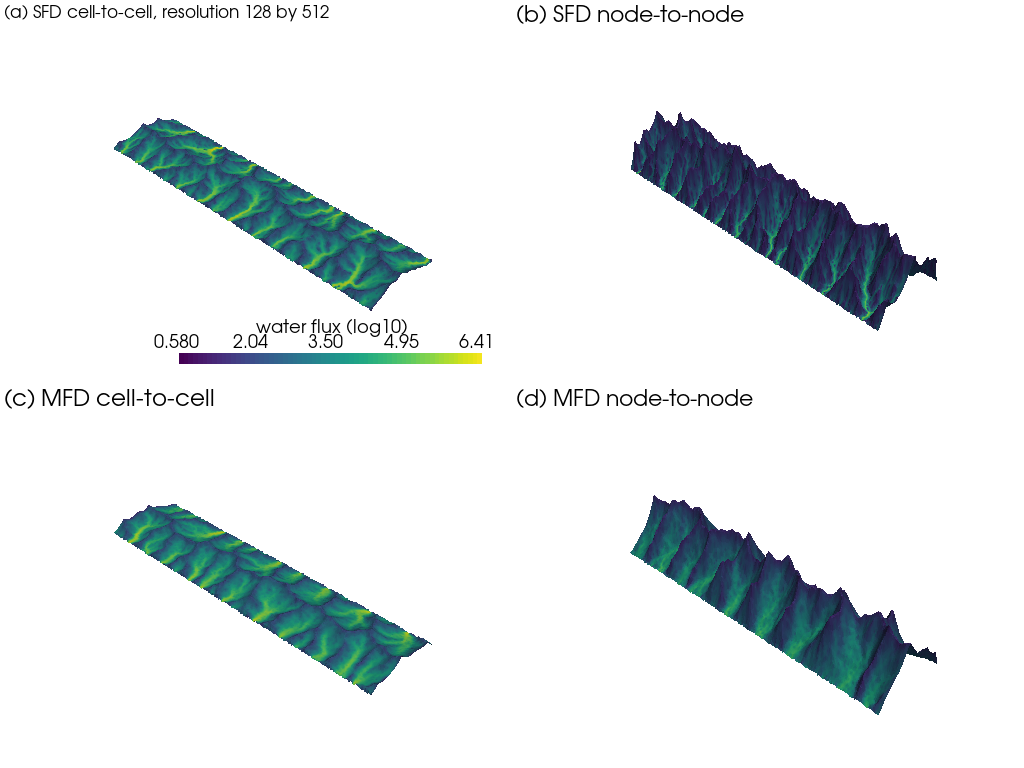

In [16]:
p.show(use_panel=False)

In [17]:
elevation = pv.read('SFDcelltocell/u_solution_512_500000000.vtu')
flux = pv.read('SFDcelltocell/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDcelltocell512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [18]:
elevation = pv.read('SFDnodetonode/u_solution_512_500000000.vtu')
flux = pv.read('SFDnodetonode/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpSFDnodetonode512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [19]:
elevation = pv.read('MFDcelltocell/u_solution_512_500000000.vtu')
flux = pv.read('MFDcelltocell/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDcelltocell512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [20]:
elevation = pv.read('MFDnodetonode/u_solution_512_500000000.vtu')
flux = pv.read('MFDnodetonode/q_solution_512_500000000.vtu')
flux['water flux (log10)'] = np.log10(flux['flx'])
flux['elevation'] = elevation['elv']
warpMFDnodetonode512 = flux.warp_by_scalar(scalars='elevation',factor=5e2)

In [21]:
p = pv.Plotter(notebook=True, shape=(2, 2), border=False)
p.subplot(0, 0)
p.add_text("(a) SFD cell-to-cell, resolution 512 by 2048", font_size=12)
p.add_mesh(warpSFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(0, 1)
p.add_text("(b) SFD node-to-node", font_size=12)
p.add_mesh(warpSFDnodetonode512, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 0)
p.add_text("(c) MFD cell-to-cell", font_size=12)
p.add_mesh(warpMFDcelltocell, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)
p.subplot(1, 1)
p.add_text("(d) MFD node-to-node", font_size=12)
p.add_mesh(warpMFDnodetonode512, scalars='water flux (log10)', cmap='viridis', lighting=True, show_scalar_bar=True)

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0x7ff295916c90

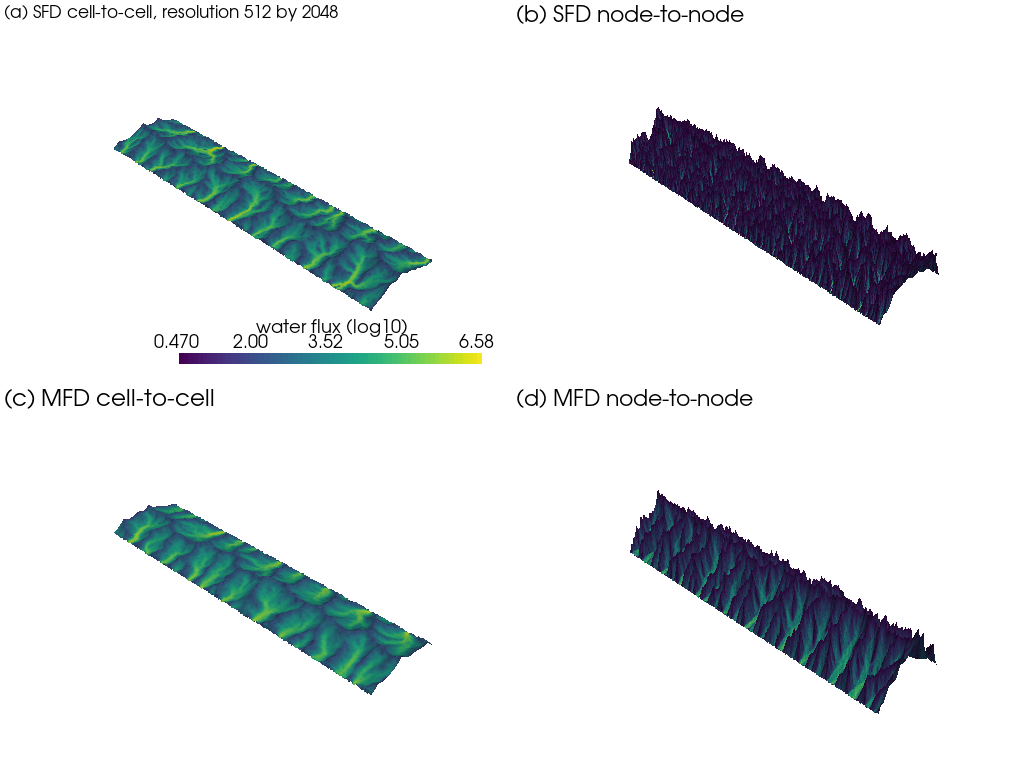

In [22]:
p.show(use_panel=False)

In [23]:
view(geometries=warpSFDcelltocell)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [24]:
view(geometries=warpSFDnodetonode)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [25]:
view(geometries=warpMFDcelltocell)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [26]:
view(geometries=warpMFDnodetonode)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Sediment flux and model resolution

In [27]:
def pltsed(file,var,xlimit,resolutions,number,colors,ly,U,kappa):
    sed = np.genfromtxt(file)
    NUMB = sed[:, 0]
    RESO = sed[:, 1]
    TIME = sed[:, 2]
    QS = sed[:, 3]

    j = 0
    for res in resolutions:
      times = TIME[np.where(RESO == res)]
      seds = QS[np.where(RESO == res)]
      nums = NUMB[np.where(RESO == res)]
      for num in number :
        plt.plot(times[np.where(nums == num)],seds[np.where(nums == num)],colors[j])
      j += 1

    Tr = 3*np.percentile(var['elevation'], 90)*ly/U*1e-6
    plt.plot((Tr, Tr), (0, 25), 'k--')  
    plt.xlim((0, xlimit))
    plt.ylim((0, 25))

In [28]:
def plotSedimentFlux():
    ly = 8e5
    U = 1e-4
    kappa = 1

    dtreal = 1e4*kappa/(ly*ly)

    resolutions = [64, 128, 256, 512]
    number = np.linspace(0, 9, 10)
    colors = ['r', 'g', 'b', 'k']

    plt.figure(figsize=(9, 6))
    plt.subplot(221)
    file = 'data/seds_SFDctc.txt'
    var = warpSFDcelltocell
    pltsed(file,var,2.5,resolutions,number,colors,ly,U,kappa)
    plt.title('SFD cell-to-cell')
    plt.ylabel('Sediment flux ($m^{2}/yr$)')

    plt.subplot(222)
    file = 'data/seds_SFDntn.txt'
    var = warpSFDnodetonode
    pltsed(file,var,7.5,resolutions,number,colors,ly,U,kappa)
    plt.title('SFD node-to-node')

    plt.subplot(223)
    file = 'data/seds_MFDctc.txt'
    var = warpMFDcelltocell
    pltsed(file,var,2.5,resolutions,number,colors,ly,U,kappa)
    plt.title('MFD cell-to-cell')
    plt.ylabel('Sediment flux ($m^{2}/yr$)')
    plt.xlabel('Time (My)')

    plt.subplot(224)
    file = 'data/seds_MFDntn.txt'
    var = warpMFDnodetonode
    pltsed(file,var,7.5,resolutions,number,colors,ly,U,kappa)
    plt.title('MFD node-to-node')
    plt.xlabel('Time (My)')

    plt.show()

In [29]:
plotSedimentFlux()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Wavelength of valleys as function of model resolution

In [30]:
def pltwav(file,ylimit):
    wave  = np.genfromtxt(file)
    ress  = wave[:,0]
    width = wave[:,2]

    wav64  = np.zeros(200)
    wav128 = np.zeros(200)
    wav256 = np.zeros(200)
    wav512 = np.zeros(200)

    i = 0
    j = 0
    k = 0
    l = 0
    m = 0
    for res in ress:
      if res == 64:
        wav64[i] = width[m]
        i += 1
      if res == 128:
        wav128[j] = width[m]
        j += 1
      if res == 256:
        wav256[k] = width[m]
        k += 1
      if res == 512:
        wav512[l] = width[m]
        l += 1
      m += 1

    x  = [64,128,256,512]
    y  = np.zeros(len(x))
    y_ = np.zeros(len(x))

    y[0] = np.mean(wav64)
    y[1] = np.mean(wav128)
    y[2] = np.mean(wav256)
    y[3] = np.mean(wav512)

    y_[0] = np.std(wav64)
    y_[1] = np.std(wav128)
    y_[2] = np.std(wav256)
    y_[3] = np.std(wav512)

    ys = [wav64,wav128,wav256,wav512]
    plt.boxplot(ys)
    plt.ylim((0,ylimit))
    plt.xticks([1, 2, 3, 4], ['64x256', '128x512', '256x1028', '512x2056'])

In [31]:
def plotWavelengths():
    plt.figure(figsize=(9, 6))
    plt.subplot(221)
    file = 'data/wavs_SFDctc.txt'
    pltwav(file,.5)
    plt.title('SFD cell-to-cell')
    plt.ylabel('Normalised wavelength')

    plt.subplot(222)
    file = 'data/wavs_SFDntn.txt'
    plt.title('SFD node-to-node')
    pltwav(file,.5)

    plt.subplot(223)
    file = 'data/wavs_MFDctc.txt'
    pltwav(file,.5)
    plt.title('MFD cell-to-cell')
    plt.xlabel('Resolution')
    plt.ylabel('Normalised wavelength')

    plt.subplot(224)
    file = 'data/wavs_MFDntn.txt'
    pltwav(file,.5)
    plt.title('MFD node-to-node')
    plt.xlabel('Resolution')

    plt.show()

In [32]:
plotWavelengths()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Conclusion

For a transport limited model distributed flow routing is a **must**, otherwise the results of the model are resolution dependent.

# Part 2: Reproducibility

### [Steps to reproducible research](https://www.nature.com/articles/d41586-020-02462-7)

**Code** Workflows based on point-and-click interfaces, such as Excel, are not reproducible. Enshrine your computations and data manipulation in code.

**Document** Use comments, computational notebooks and README files to explain how your code works, and to define the expected parameters and the computational environment required.

**Record** Make a note of key parameters, such as the ‘seed’ values used to start a random-number generator. Such records allow you to reproduce runs, track down bugs and follow up on unexpected results.

**Test** Create a suite of test functions. Use positive and negative control data sets to ensure you get the expected results, and run those tests throughout development to squash bugs as they arise.

**Guide** Create a master script (for example, a `run.sh` file) that downloads required data sets and variables, executes your workflow and provides an obvious entry point to the code.

### [Steps to reproducible research](https://www.nature.com/articles/d41586-020-02462-7)

**Archive** GitHub is a popular but impermanent online repository. Archiving services such as Zenodo, Figshare and Software Heritage promise long-term stability.

**Track** Use version-control tools such as Git to record your project’s history. Note which version you used to create each result.

**Package** Create ready-to-use computational environments using containerization tools (for example, Docker, Singularity), web services (Code Ocean, Gigantum, Binder) or virtual-environment managers (Conda).

**Automate** Use continuous-integration services (for example, Travis CI) to automatically test your code over time, and in various computational environments.

**Simplify** Avoid niche or hard-to-install third-party code libraries that can complicate reuse.

**Verify** Check your code’s portability by running it in a range of computing environments.

### These are (for me) the most important

**Code** Workflows based on point-and-click interfaces, such as Excel, are not reproducible. Enshrine your computations and data manipulation in code.

**Document** Use comments, computational notebooks and README files to explain how your code works, and to define the expected parameters and the computational environment required.

**Archive** GitHub is a popular but impermanent online repository. Archiving services such as Zenodo, Figshare and Software Heritage promise long-term stability.

**Package** Create ready-to-use computational environments using containerization tools (for example, Docker, Singularity), web services (Code Ocean, Gigantum, Binder) or virtual-environment managers (Conda).

### Excel is not fit for research

Use `R` or `python` for data analysis. Even the simple things, like making a bar chart:

In [33]:
data = gpd.read_file('data/GRWL_summaryStats.shp')
fig = plt.figure()
ax = data['width_mean'].plot(kind='hist',bins=10)
ax.set_xlabel('Mean river width (m)')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Excel is not fit for research

Use `R` or `python` for data analysis. Nor for regression analysis, for example the [Milliman & Farnsworth data set for river discharge](https://www.cambridge.org/fr/academic/subjects/earth-and-environmental-science/geomorphology-and-physical-geography/river-discharge-coastal-ocean-global-synthesis?format=PB&isbn=9781107612181) from their book 'River Discharge to the Coastal Ocean'.

In [34]:
dfm = pd.read_csv('./data/milliman-farnsworth-database.csv',na_values=('<1','#VALUE!'))
dfm.columns.values
dfm.Max_Elev.describe()

count     1220
unique     150
top       >500
freq       135
Name: Max_Elev, dtype: object

In [35]:
dfm.Climate_T.unique()

array(['STr', 'Tr', 'Str', 'Te', 'Ar', 'SAr', nan], dtype=object)

This is a mess!

In [36]:
dfm['Max_Elev'] = dfm['Max_Elev'].apply(lambda x: np.nan if (str(x).startswith('>')) | (str(x).startswith('<')) else float(x))
dfm['Max_Elev'] = dfm['Max_Elev'].apply(lambda x: np.nan if (x < 10) else float(x))
dfm['Runoff'] = dfm['Runoff'].apply(lambda x: np.nan if (str(x).startswith('>')) | (str(x).startswith('<')) else float(x))
dfm['Q'] = dfm['Q'].apply(lambda x: np.nan if (x == 0.) else float(x))
dfm['Climate_T'] = dfm['Climate_T'].apply(lambda x: "STr" if (x == "Str") else x)
dfm['Area'] = dfm['Area, km^2']

Now we can plot the data...

In [37]:
fig = plt.figure()
groups = dfm.groupby('Climate_T')
for Climate_T, group in groups:
    plt.loglog(group.Area, group.Q, marker='o', linestyle='', ms=2, label=Climate_T)
plt.legend(('Arctic','Subarctic','Subtropical','Temperate','Tropical'))
plt.xlabel("Catchment area (km$^2$)")
plt.ylabel("Water flux (km$^3$yr$^{-1}$)")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

...and get regressions for "Subtropical" type:

In [38]:
dfm['logA'] = np.log10(dfm['Area'])
dfm['logQ'] = np.log10(dfm['Q'])
groups = dfm.groupby('Climate_T')

In [39]:
dft = groups.get_group('STr')
fig = plt.figure()
model = sm.OLS(dft.logQ,sm.add_constant(dft.logA),missing='drop').fit()
xx = np.arange(1e2,1e7)
yy = np.power(10,model.params[0])*np.power(xx,model.params[1])
plt.loglog(xx,yy)
plt.xlabel("Catchment area (km$^2$)")
plt.ylabel("Water flux (km$^3$yr$^{-1}$)")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

For example the regression for a subtropical climate is:

In [40]:
X = groups['logA'].get_group('STr')
y = groups['logQ'].get_group('STr')
model = sm.OLS(y,sm.add_constant(X),missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     79.83
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           9.50e-17
Time:                        17:31:27   Log-Likelihood:                -279.57
No. Observations:                 250   AIC:                             563.1
Df Residuals:                     248   BIC:                             570.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1780      0.235     -9.282      0.000      -2.640      -1.716
logA           0.5458      0.061      8.935      0.000       0.425       0.666
==============================================================================
Omnibus:                        5.797   Durbin-Watson:                   0.371
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.951
Skew:                          -0.364   Prob(JB):                       0.0510
Kurtosis:                       2.794   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Focus on **Package**: Dependencies and an environment

With a *package manager* such as `conda` you can define the needs of your environment. This presentation used a few python packages such as `pyvista`, `matplotlib`, etc. I manage these packages with an environment and an associated text file that lists the packages `environment.yml`:
```
name: reproducible-presentation
channels:
  - conda-forge
  - pyviz
dependencies:
  - python>=3
  - matplotlib
  - scipy
  - jupyterlab
  - voila
  - voila-reveal
  - rise
  - jupyter_nbextensions_configurator
  - vtk
  - pyvista
  - pyqt
  - ipywidgets
  - itkwidgets
  - bokeh
  - pyviz_comms
  - panel
  - nodejs
  - pandas
  - geopandas
  - statsmodels
  # flem
  - fenics=2019.1.0=py37_1
  - mshr=2019.1.0=py37h7596e34_1000
  - gdal
  - peakutils
  - pip
  - pip:
    - flem
    - elevation

```

### Dependencies and an environment

I create the environment with the command:
```
conda create env -f environment.yml
```
and I keep that file up-to-date.

### What about making a tiny computer to contain that environment only?

### Docker containers

* These are *virtual* computers that do only one process.
* That process could be to run a notebook server with my environment.
* A docker container is defined by a Dockerfile:



```
# Base image, in this case a simple linux + python machine
FROM python:3.8.0-buster
# Copy all local files (.) to the home directory of the container (.)
COPY . .
# Install all the dependencies declared in the list
RUN pip3 install -r requirements.txt
# Run the python script upon startup
CMD python3 script.py
```

### [Dockerfile for a notebook](https://github.com/johnjarmitage/reproducible-presentation/tree/master/docker_example)
```
FROM jupyter/scipy-notebook:76402a27fd13
USER root
COPY environment.txt ${HOME}
COPY Pommeroye_catchement_2016_2017.csv ${HOME}
COPY Pommeroye_data_explore.ipynb ${HOME}
RUN chown -R ${NB_UID} ${HOME}
USER ${NB_USER}
RUN conda update -n base conda
RUN conda install --quiet --yes -c conda-forge --file environment.txt
RUN pip install seaborn
```

### That was not fun

But luckily it does not have to be so hard: https://mybinder.org/

[Lets look at this presentation again](https://github.com/johnjarmitage/reproducible-presentation)